### Chargement des packages 

In [58]:
from matplotlib import pylab as plt

import lsst.daf.persistence as dp
import lsst.afw.display as display
import lsst.afw.display.rgb as rgb
import lsst.geom as geom

import numpy as np
import os, glob

import mysql
from mysql.connector import Error

import pandas as pd
import cv2
from tifffile import imread, imwrite

import matplotlib.cm as cm


### Butler 

In [36]:
repo = "/sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1"
butler = dp.Butler(repo)

lsst.CameraMapper INFO: Loading exposure registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/registry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading exposure registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/registry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib

In [ ]:
tract = 4226
patch = (6,4)

In [37]:
# Collect tract indices from file names
tracts = sorted([int(os.path.basename(x)) for x in
                 glob.glob(os.path.join(repo, 'deepCoadd-results', 'merged', '*'))])
num_tracts = len(tracts)

print("Found {} merged tracts in repo {}".format(num_tracts, repo))

Found 173 merged tracts in repo /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1


In [38]:
skyMap = butler.get("deepCoadd_skyMap")
tractInfo = skyMap[tract]
print(tractInfo)

TractInfo(id=4226)


In [39]:
patchs = sorted([os.path.basename(x) for x in
                 glob.glob(os.path.join(repo, 'deepCoadd-results', 'merged', str(tract), '*'))])

In [40]:
patchInfo = tractInfo.getPatchInfo(patch)

In [41]:
poly = patchInfo.getInnerSkyPolygon(tractInfo.getWcs())
wcs = tractInfo.getWcs()
vertices = poly.getVertices()
boxRa = []
boxDec = []
for pt in poly.getVertices():
    boxRa.append(geom.SpherePoint(pt).getRa().asDegrees())
    boxDec.append(geom.SpherePoint(pt).getDec().asDegrees())

In [42]:
print(np.min(boxRa), np.max(boxRa))
print(np.min(boxDec), np.max(boxDec))

53.77472182809934 54.04242848258739
-33.35816232788211 -33.13427110049693


In [43]:
ra_min = np.min(boxRa)
ra_max = np.max(boxRa)
dec_min = np.min(boxDec)
dec_max = np.max(boxDec)

In [44]:
conn = mysql.connector.connect(host='ccqserv201', user='qsmaster', port=30040) 
cursor = conn.cursor(dictionary=True, buffered=True) 

In [45]:
query = "SHOW DATABASES;"
cursor.execute(query)
res = cursor.fetchall()
res

[{'Database': 'cosmoDC2_v1_1_4_image'},
 {'Database': 'dc2_object_run22i_dr6_wfd_v2_00'},
 {'Database': 'dp01_dc2_catalogs'},
 {'Database': 'information_schema'},
 {'Database': 'qservCssData'},
 {'Database': 'qservMeta'},
 {'Database': 'qservResult'},
 {'Database': 'test'}]

In [46]:
query = "SHOW TABLES IN cosmoDC2_v1_1_4_image;"
cursor.execute(query)
cursor.fetchall()

[{'Tables_in_cosmoDC2_v1_1_4_image': 'data'},
 {'Tables_in_cosmoDC2_v1_1_4_image': 'position'}]

In [47]:
mmin = 1.e14 #Msun
zmax = 1.3
#z0max = 1.5 #Rest-frame absolute magnitude, not lensed, in 'z'


query = "SELECT data.coord_ra, data.coord_dec, data.halo_mass, data.redshift, data.Mag_true_z_lsst_z0, data.is_central, data.halo_id "
query += "FROM cosmoDC2_v1_1_4_image.data as data "
query += f"WHERE scisql_s2PtInBox(data.coord_ra, data.coord_dec, {ra_min}, {dec_min}, {ra_max}, {dec_max}) = 1 "
query += f"AND data.halo_mass>{mmin} AND data.redshift<{zmax} "
#query += "AND data.is_central = 1 " 
#query += f"AND data.Mag_true_z_lsst_z0 < {z0max} "
query += ";"
query

'SELECT data.coord_ra, data.coord_dec, data.halo_mass, data.redshift, data.Mag_true_z_lsst_z0, data.is_central, data.halo_id FROM cosmoDC2_v1_1_4_image.data as data WHERE scisql_s2PtInBox(data.coord_ra, data.coord_dec, 53.77472182809934, -33.35816232788211, 54.04242848258739, -33.13427110049693) = 1 AND data.halo_mass>100000000000000.0 AND data.redshift<1.3 ;'

In [48]:
%%time
tab = pd.read_sql_query(query,conn)
len(tab)

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2022_07/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/pandas/io/sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


CPU times: user 9.22 ms, sys: 0 ns, total: 9.22 ms
Wall time: 3.17 s


947

In [49]:
z = tab.groupby(['halo_id'])
z.size()

halo_id
8400079442         7
89500079411        9
297700093382     403
381700093279     138
784400093331     161
822700093338       8
1175500093279      9
1536700079279    136
1855000093279     76
dtype: int64

In [50]:
skyBbox = []
for halo, df in z:
    if len(df) < 5 :
        continue
    min = geom.SpherePoint(df.coord_ra.min()*geom.degrees, df.coord_dec.min()*geom.degrees)
    max = geom.SpherePoint(df.coord_ra.max()*geom.degrees, df.coord_dec.max()*geom.degrees)
    print(halo, df.halo_id.to_list()[0], min, max, df.redshift.to_list()[0], df.halo_mass.to_list()[0]*1.e-14)
    skyBbox.append([halo, min, max])

8400079442 8400079442 (54.0102391634, -33.3510075889) (54.0424224016, -33.1721793450) 0.11556777974270438 2.050680293174085
89500079411 89500079411 (53.9867364819, -33.2066217898) (54.0413878478, -33.1542133753) 0.1965158630441588 2.0009039473938026
297700093382 297700093382 (53.7747348040, -33.3580023527) (54.0413296498, -33.2017109794) 0.28581871336402087 6.2471513896238875
381700093279 381700093279 (53.7753117360, -33.2664633379) (53.8408477606, -33.2041619606) 0.772934887326115 1.8328340508845071
784400093331 784400093331 (53.7853130874, -33.3542028397) (53.9692782903, -33.2363988664) 0.48450458384923034 2.272685394641127
822700093338 822700093338 (53.8815898268, -33.3579085914) (53.9411478020, -33.3444787032) 0.452727893224947 1.0081582688630986
1175500093279 1175500093279 (53.7750650326, -33.2073327813) (53.8227423937, -33.1652109757) 0.7712397564888536 1.2308911706861971
1536700079279 1536700079279 (53.9101049675, -33.1999422494) (53.9822249164, -33.1422698066) 0.771406440637028

In [51]:
innerBbox = patchInfo.getInnerBBox()
outerBbox = patchInfo.getOuterBBox()
dX = 0.5*(outerBbox.getWidth()-innerBbox.getWidth())
dY = 0.5*(outerBbox.getHeight()-innerBbox.getHeight())

In [52]:
print(innerBbox)
print(outerBbox)

(minimum=(24000, 16000), maximum=(27999, 19999))
(minimum=(23900, 15900), maximum=(27999, 20099))


In [53]:
innerBbox = patchInfo.getInnerBBox()
outerBbox = patchInfo.getOuterBBox()
dX = innerBbox.beginX-outerBbox.beginX
dY = innerBbox.beginY-outerBbox.beginY
print(dX, dY)

100 100


In [54]:
# Get the 6 band image corresponding to a given tract, patch
patchName = str(patch[0]) + ',' + str(patch[1])
dataId = {'tract':tract, 'patch':patchName}
im = {}
filters = ['r', 'i', 'g']

for f in filters:
    dataId['filter'] = f
    exp = butler.get('deepCoadd', dataId=dataId).getMaskedImage()[innerBbox]

    im[f] = exp.getImage().getArray()
    # We need to keep the reference coordinates X0, Y0 to convert image coordinates into natural CCD coordinates
    if f == 'r':
        X0 = exp.getX0()
        Y0 = exp.getY0()

In [55]:
rgb_im = rgb.makeRGB(im['r'], im['i'], im['g'], Q=8, minimum = -0.1, dataRange=1.5, 
                       saturatedPixelValue=100,
                       xSize=None, ySize=None)

### Ancien code

### Affichage

[0.12156863 0.46666667 0.70588235 1.        ]
X :  [463.80546148412395, 463.80546148412395, -9.572451246043784, -9.572451246043784, 463.80546148412395]
Y :  [120.29602045925458, 3352.4907915405092, 3352.4907915405092, 120.29602045925458, 120.29602045925458]
[1.         0.49803922 0.05490196 1.        ]
X :  [835.2080256619811, 835.2080256619811, 8.084735931850446, 8.084735931850446, 835.2080256619811]
Y :  [2716.9530434163025, 3675.7973674836685, 3675.7973674836685, 2716.9530434163025, 2716.9530434163025]
[0.17254902 0.62745098 0.17254902 1.        ]
X :  [4004.05606418919, 4004.05606418919, 3.4922871880044113, 3.4922871880044113, 4004.05606418919]
Y :  [-33.256294612087004, 2820.789710409903, 2820.789710409903, -33.256294612087004, -33.256294612087004]
[0.83921569 0.15294118 0.15686275 1.        ]
X :  [4010.1423080071763, 4010.1423080071763, 3023.0048633227416, 3023.0048633227416, 4010.1423080071763]
Y :  [1614.6221579602789, 2754.595679697348, 2754.595679697348, 1614.6221579602789, 

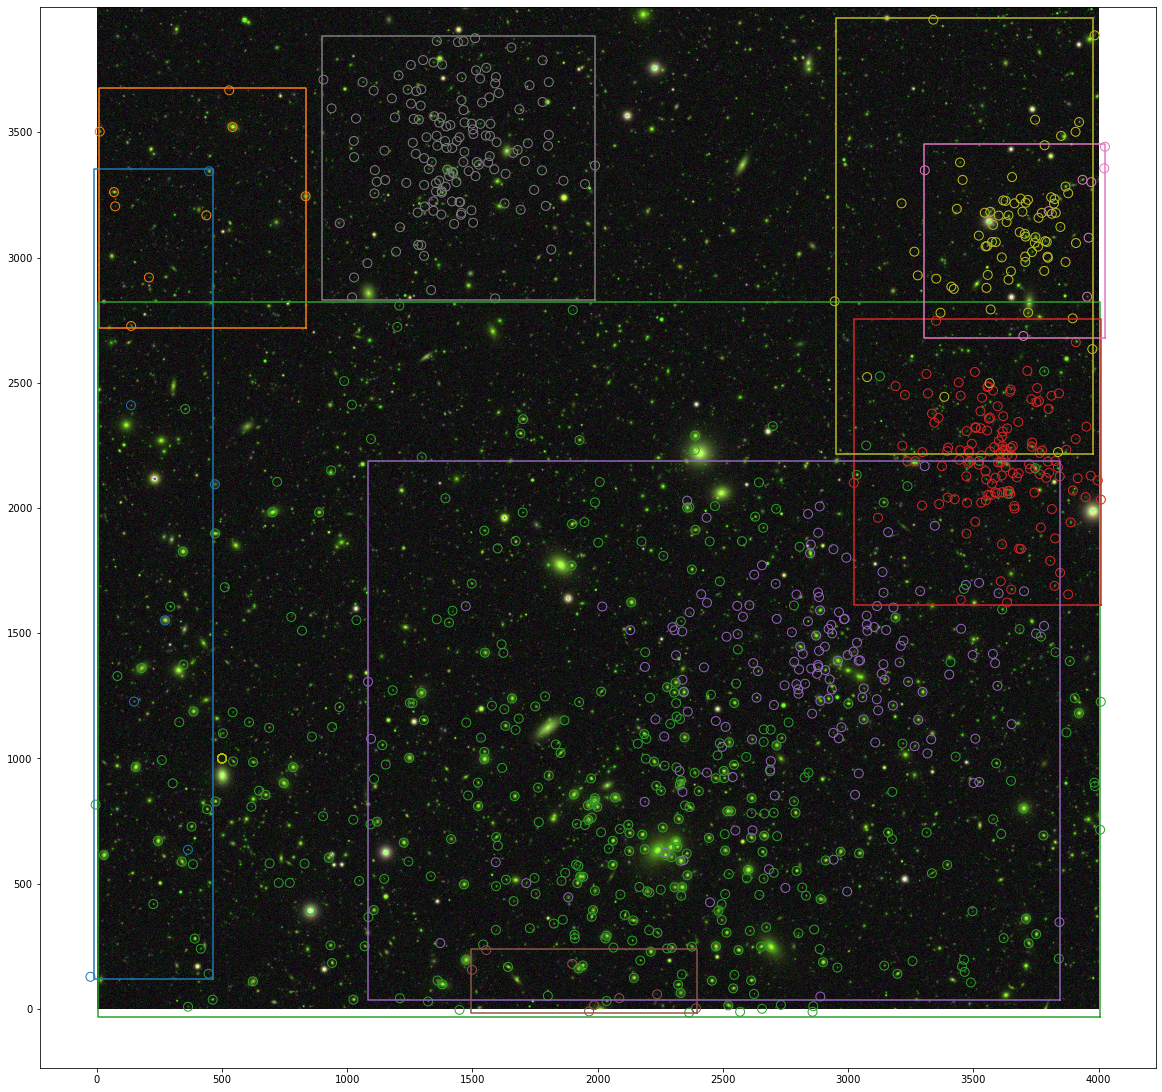

In [76]:
colors = cm.tab10(np.linspace(0, 1, 10))

e = 5
display.setDefaultBackend("matplotlib")

fig = plt.figure(figsize=(20, 20))
disp = rgb.displayRGB(rgb_im, show=False)
#disp.line([(8500, 24000), (8500, 25000)], ctype='yellow')

for sky, c in zip(skyBbox, colors):
    print(c)
    box = wcs.skyToPixel(sky[1:])
    X = [box[0].getX()-X0+e, box[0].getX()-X0+e, box[1].getX()-X0-e, box[1].getX()-X0-e, box[0].getX()-X0+e]
    print("X : ", X)
    Y = [box[0].getY()-Y0-e, box[1].getY()-Y0+e, box[1].getY()-Y0+e, box[0].getY()-Y0-e, box[0].getY()-Y0-e]
    print("Y : ", Y)
    disp.plot(X,Y, color=c)

count = 0
for halo, df in z:
    if len(df) < 5 :
        continue
    c = colors[count]
    count += 1
    galX = []
    galY = []
    for k in range(len(df)):
        p = geom.SpherePoint(list(df.coord_ra)[k]*geom.degrees, list(df.coord_dec)[k]*geom.degrees)
        galX.append(wcs.skyToPixel(p).getX()-X0)
        galY.append(wcs.skyToPixel(p).getY()-Y0)
    disp.scatter(galX, galY, s=80, facecolors='none', edgecolors=c)
    disp.scatter([500], [1000], s=80, facecolors='none', edgecolors="y")